In [31]:
import re
import numpy as np
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.plot import *
from matplotlib import patches
from matplotlib.cm import get_cmap
from adjustText import adjust_text
from matplotlib.colors import ListedColormap, Normalize

In [32]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [33]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv', 
    index_col=0
)
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
for tf_col in ['Class', 'Family', 'SubFamily']:
    gene_class_map = {}
    for _, (class_name, genes) in tf_class[[tf_col, 'EnsemblID']].iterrows():
        if isinstance(genes, float):
            continue
        for gene in genes.split(','):
            gene_class_map[gene] = class_name
    
    motif_gene_anno[tf_col] = motif_gene_anno['gene_ids'].apply(lambda i: gene_class_map.get(i.split('.')[0], ''))

motif_gene_anno['SubFamily'] = motif_gene_anno['SubFamily'].replace('', np.nan).fillna('unclassified')
motif_gene_anno.head()

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0006.1,Ahr::Arnt,"Ahr,Arnt","ENSMUSG00000019256.17,ENSMUSG00000015522.18","Ahr,Arnt",MotifGroup178,Basic helix-loop-helix factors (bHLH),PAS,PAS-AHR
MA0854.1,Alx1,Alx1,ENSMUSG00000036602.14,Alx1,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0634.1,ALX3,ALX3,ENSMUSG00000014603.3,Alx3,MotifGroup3,Homeo domain factors,Paired-related HD,TPRX
MA0853.1,Alx4,Alx4,ENSMUSG00000040310.12,Alx4,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0007.3,Ar,Ar,ENSMUSG00000046532.8,Ar,MotifGroup32,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors,GR-like(NR3C)


## Cell Tidy Data

In [4]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Exc']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
subtype_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

## Tree and gene assignment

In [6]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.linkage.csv',
    header=0,
    index_col=0)
node_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.non_singleton_node_dict.lib'
)

gene_assignment = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMR/NodeMotifResults.msg'
)

In [7]:
gene_assignment = gene_assignment[gene_assignment.index >= 142].copy()
gene_assignment.tail()

,MA0003.4,MA0018.4,MA0025.2,MA0039.4,MA0032.2,MA0027.2,MA0040.1,MA0019.1,MA0033.2,MA0031.1,...,MA1633.1,MA1635.1,MA1634.1,MA1641.1,MA1648.1,MA1638.1,MA1652.1,MA1653.1,MA1642.1,MA1683.1
142,0.000000,0.003663,-0.043956,0.000000,-0.358974,-0.135531,-0.285714,0.000000,-0.725275,-0.732601,...,0.179487,0.952381,0.208791,0.952381,0.000000,0.831502,0.032967,0.000000,0.838828,-0.736264
143,0.060847,0.010582,0.000000,0.111111,-0.018519,-0.013228,-0.063492,0.248677,0.058201,0.058201,...,0.854497,0.000000,1.000000,0.005291,-0.267196,-0.587302,0.126984,0.015873,-0.793651,0.052910
144,0.024887,-0.017345,0.014329,0.046003,0.028658,0.168929,0.092760,-0.267722,0.076923,0.073906,...,0.012066,-0.029412,-0.088989,-0.188537,-0.032428,-0.304676,-0.012066,0.004525,-0.288084,0.075415


## Normalize linkage height to 0-1

In [8]:
linkage['2'] = linkage['2'] / linkage['2'].max()

## Plot

In [9]:
rs_abs_min = 0.3

records = gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

tf_total_data = use_data.copy()
tf_sum_rs = total_rs_data.copy()

(166, 5)


## TF genes

In [10]:
motif_gene_anno['total_rs'] = tf_sum_rs
motif_gene_anno = motif_gene_anno.loc[tf_sum_rs.index].copy()

In [11]:
motif_gene_anno.groupby(['motif_group', 'SubFamily'])['total_rs'].mean().reset_index()

,motif_group,SubFamily,total_rs
0,MotifGroup0,unclassified,0.292933
1,MotifGroup125,ROR(NR1F),1.603251
2,MotifGroup13,POU2,0.382353
3,MotifGroup13,POU3,0.369532
4,MotifGroup26,unclassified,0.750431
5,MotifGroup3,EMX,0.248993
6,MotifGroup3,HOX1,0.248993
7,MotifGroup3,HOX2,0.248993
8,MotifGroup3,HOX5,0.248993
9,MotifGroup3,PAX4-like,0.260710


In [34]:
tf_sum_rs.shape

(113,)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


10

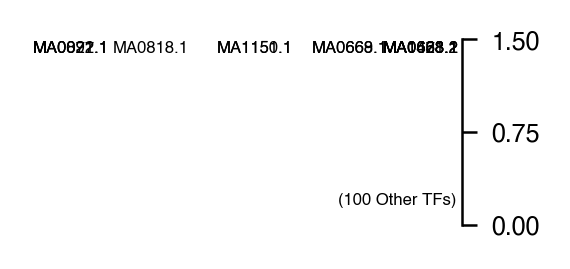

In [19]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 1.5

df = tf_sum_rs[tf_sum_rs > label_y_cutoff]
other_count = tf_sum_rs[tf_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other TFs)'] = 0.2

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 1.5)
ax.set_yticks([0, 0.75, 1.5])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })



In [20]:
tf_sum_rs.size, tf_sum_rs.groupby(motif_gene_anno['SubFamily']).median().size

(113, 43)

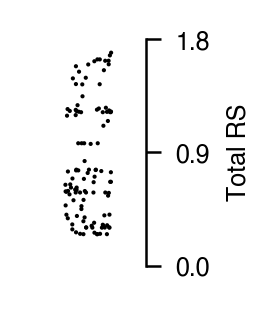

In [24]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)
sns.stripplot(y=tf_sum_rs, jitter=0.2, s=1, color='k')
sns.despine(ax=ax, bottom=True, left=True, right=False)
ax.set_ylabel('Total RS')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.set_ylim(0, 1.5)
ax.set_yticks([0, 0.9, 1.8])

ax.set_xticks([])

fig.savefig('Layer.Motif.total_rs.strip_plot.scatter_part.pdf')

In [25]:
tf_sum_rs.to_csv('Layer.motif.sum_rs.csv', header=False)

## Plot logos


In [29]:
from ALLCools.motif.utilities import *

pfm_dict = meme_to_pfm_dict(
    '/home/hanliu/ref/MEME/selected_motifs_sets/JASPAR2020_CORE_vertebrates_non-redundant_pfms.meme'
)

use_top = tf_sum_rs.groupby(motif_gene_anno['SubFamily']).median().sort_values(ascending=False)[:30]
use_top

SubFamily
ROR(NR1F)         1.591257
Neurogenin-ATO    1.522008
TAL-HEN           1.295647
Fos               1.232158
R-MAD             1.223370
ATF3-like         1.218535
Jun               1.192836
TWIST             1.110586
Myogenic TFs      0.758697
E2A-like          0.735262
NFE2              0.724731
ASC               0.719151
FOXF              0.705969
FOXN              0.688393
FOXG              0.664958
MESP              0.662029
Small MAF         0.619362
FOXJ              0.603442
FOXP              0.600513
FOXO              0.580008
FOXI              0.580008
FOXA              0.577078
CUX               0.573906
FOXL              0.572684
FOXD              0.531674
unclassified      0.518492
FOXK              0.471622
FOXB              0.404248
MEF2              0.400915
POU2              0.382353
Name: impact, dtype: float64

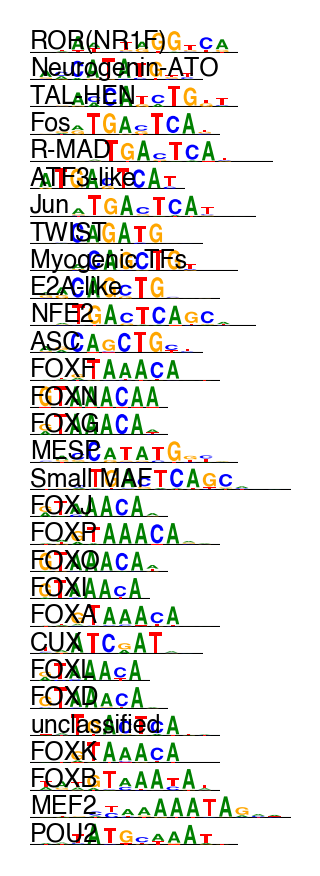

In [30]:
motifs = tf_sum_rs.groupby(motif_gene_anno['SubFamily']).idxmax().loc[use_top.index]
pfms = {k:pfm_dict[v] for k,v in motifs.items()}

max_col = max((i.shape[0] for i in pfms.values()))

fig = plt.figure(figsize=(1.5, 3.6), dpi=300)

gs = fig.add_gridspec(len(pfms), 20)

for i, (name, pfm) in enumerate(pfms.items()):
    ax = fig.add_subplot(gs[i, :pfm.shape[0]])
    plot_pfm(pfm=pfm, ax=ax)
    ax.axis('off')
    ax.text(0, 0.5, name, fontsize=6,
            ha='left', va='center', transform=ax.transAxes)

fig.savefig('Layer.Motif.top_logos.pdf')